# Исследование объявлений о продаже квартир

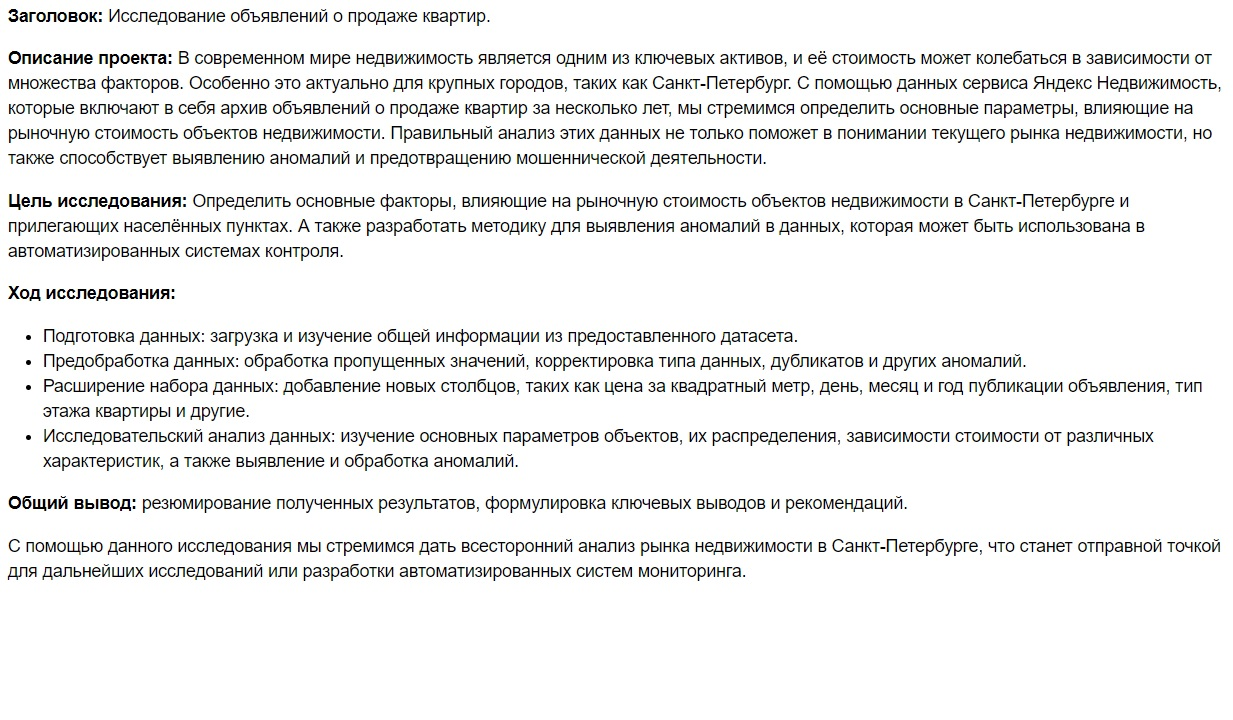

### Общая информация о файле с данными

In [1]:
#Открою файл
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
data=pd.read_csv('/datasets/real_estate_data.csv',sep='\t',engine='python')
shap=data.shape[0]
print(shap)
data.head()

23699


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

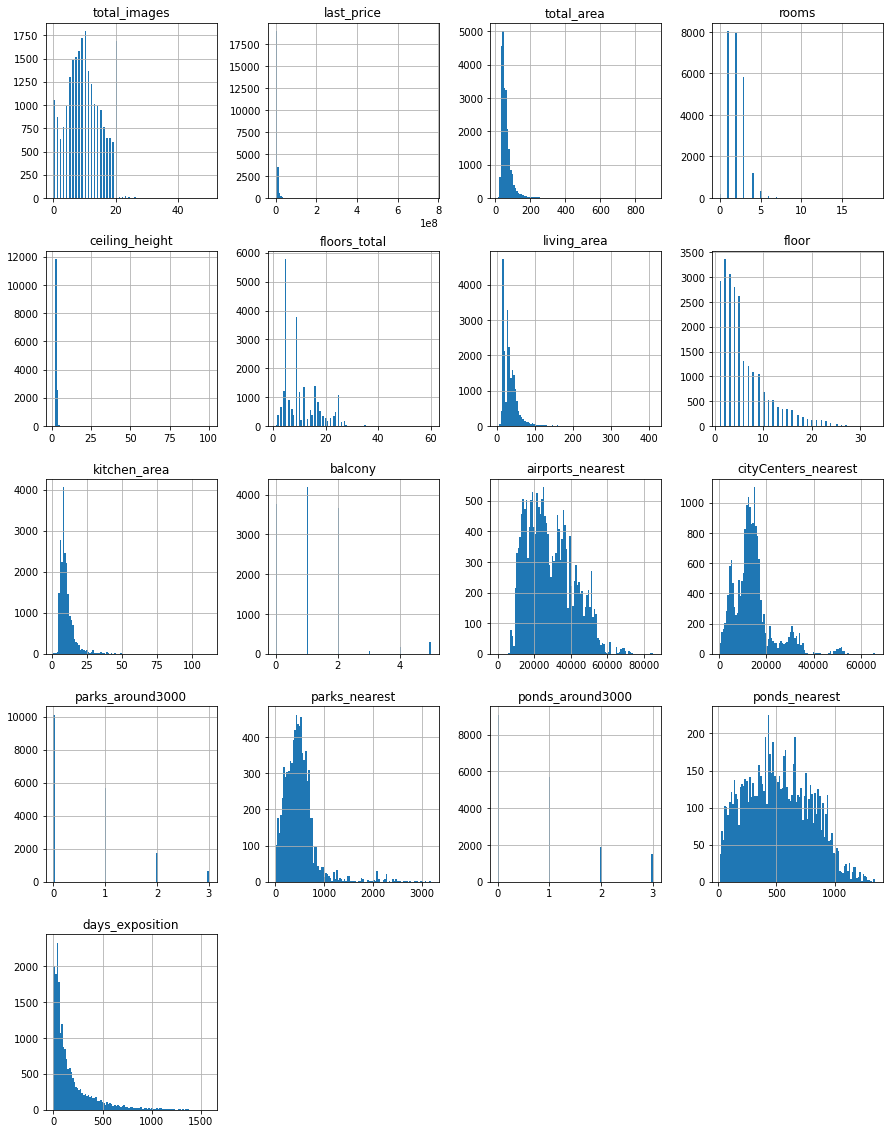

In [3]:
data.hist(bins=100,figsize=(15,20));

Замечу, что в гистограммах столбцов 'days_exposition' и 'total_images' очень много нулей, что странно, поскольку так много квартир не может продаваться в тот же день, а также вряд ли найдутся люди, готовые покупать квартиру без приложенных фото.

### Предобработка данных

In [4]:
#Выведу все столбцы, в которых есть пропуски
nulls=[]
for i in data.columns:
    if data[i].isna().values.any():
        nulls.append(i)
nulls

['ceiling_height',
 'floors_total',
 'living_area',
 'is_apartment',
 'kitchen_area',
 'balcony',
 'locality_name',
 'airports_nearest',
 'cityCenters_nearest',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest',
 'days_exposition']

В столбце 'days_exposition' пропуски могут возникнуть, когда объвление было размещено и снято в один день, поэтому также заменим пропуски на 0.
Заметим, что в столбце 'floors_total' 23613 ненулевых значений и 86 нулевых, что составляет менее одного процента от количества значений, значит можно удалить все строки с пропусками в этом столбце без ощутимой потери данных.

In [5]:
data['balcony']=data['balcony'].fillna(0)
data=data.dropna(subset=['floors_total'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        14495 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               23613 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Рассмотрю распределение пропусков в данном столбце относительно года выставления квартиры на продажу.

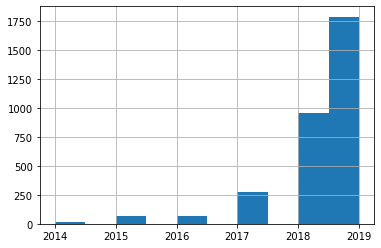

In [6]:
pd.options.mode.chained_assignment = None
data4=data[pd.array(data['days_exposition'].isnull())]
data4['first_day_exposition'] = pd.to_datetime(data4['first_day_exposition'], format='%Y-%m-%d %H:%M')
data4['year']=data4['first_day_exposition'].dt.year
data4['year'].hist();

Замечу, что пропуски в столбце 'days_exposition' возникают преимущественно в 2018 и 2019. Возможно это означает, что существует максимальная верхняя граница дней существования объявления, а после ее достижения значение исчезает, и к 2018 и 2019 году многие объявления уже превысили время существования на сайте. Пропуск в этой колонке означает, что объект не продан и объявление не закрыто. Поэтому заполнять пропуски в этом столбце не надо - они не случайные и существенно влияют на статистику.

Столбцы 'floors_total','balcony' должны иметь тип int64, поскольку не могут быть представлены в виде дробного числа.
Столбец 'is_apartment' согласно условию должен иметь булев тип, поэтому изменим его на булев

In [7]:
change=['floors_total','balcony']
for i in change:
    data[change]=data[change].astype(int)
data['is_apartment']=data['is_apartment'].astype(bool)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        14495 non-null  float64
 6   floors_total          23613 non-null  int64  
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               23613 non-null  int64  
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [8]:
#Заменю все буквы ё на е
data['locality_name'] = (data['locality_name'].str.replace('ё', 'е'))
#Сокращу названия локаций до минимально возможного
data['locality_name'] = (data['locality_name'].replace(['nan','прижелезнодорожной',' ','коттеджный','станции','прижелезнодорожнойстанции','поселок ', 'деревня ','село ','городского типа','садовое товарищество ','городской '], '', regex=True))
#Удалю все явные дубликаты
data.drop_duplicates(subset=['locality_name'])
len(data['locality_name'].unique())

329

### Добавление в таблицу новых столбцов

In [9]:
#Добавлю столбец с ценой за квадратный метр
data['square_metr_price']=round(data['last_price']/data['total_area'],2)
#Добавлю столбцы с названием дня недели, месяца и года
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
weekdays=['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресенье']
months=['Январь','Февраль','Март','Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']
data['weekday'] = data['first_day_exposition'].dt.weekday
data['monthday'] = data['first_day_exposition'].dt.month
data['year']=data['first_day_exposition'].dt.year
data['weekday']=data['weekday'].apply(lambda x:weekdays[x])
data['monthday']=data['monthday'].apply(lambda x:months[x-1])
#Создам функцию определения этажа и добавлю столбец с типом этажа
def tip(floor,maxe):
    if floor==1:
        return 'первый'
    elif floor==maxe:
        return 'Последний'
    else:
        return  'другой'
data['floortype']=data.apply(lambda x: tip(x['floor'],x['floors_total']),axis=1)
#Добавлю столбец со значение расстояния до центра города в километрах
data['km_from_cityCenters']=(data['cityCenters_nearest']/1000).round()
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_metr_price,weekday,monthday,year,floortype,km_from_cityCenters
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,Четверг,Март,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,True,False,False,11.0,2,поселокШушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,Вторник,Декабрь,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,True,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,Четверг,Август,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,True,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,Пятница,Июль,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,Вторник,Июнь,2018,другой,8.0


### Проведите исследовательский анализ данных

**Общая площадь**

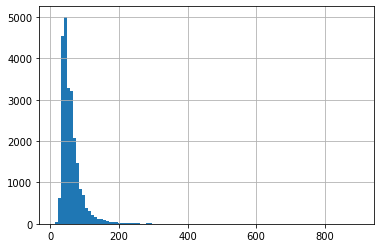

In [10]:
data['total_area'].hist(bins=100);

In [11]:
print(data['total_area'].min(),data['total_area'].max(),data['total_area'].median())
len(data.query('total_area<9'))

12.0 900.0 52.0


0

Учетной нормой в Санкт-Петербурге исчитается 9 м2 на человека в отдельной квартире и 15 — в коммунальной. В данном столбце особых аномалий не выявлено, все значения площади квартиры лежат в пределах нормы от 12 до 900.

**Жилая площадь**

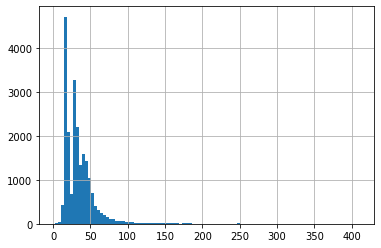

In [12]:
data['living_area'].hist(bins=100);

In [13]:
print(data['living_area'].min(),data['living_area'].max(),data['living_area'].median());

2.0 409.7 30.0


В столбце с информацией о размере жилой площади можно заметить, что минимальное значение составляет 2 квадратных метра. Такое сложно представить, но в теории это возможно.

**Площадь кухни**

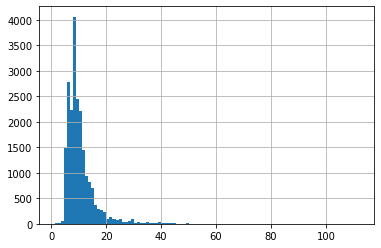

In [14]:
data['kitchen_area'].hist(bins=100);

In [15]:
print(data['kitchen_area'].min(),data['kitchen_area'].max(),data['kitchen_area'].median())

1.3 112.0 9.1


В столбце 'kitchen_area' значения ранжируются от 1.3 до 112. На кухне 1.3 м2 например, при общей площади квартиры 12 м2 вполне реально.

**Цена объекта**

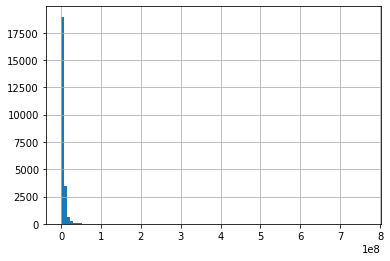

In [16]:
data['last_price'].hist(bins=100);

In [17]:
print(data['last_price'].min(),data['last_price'].max(),data['last_price'].median())
len(data.query('last_price<400000'))

12190.0 763000000.0 4650000.0


1

Замечу, что минимальное значение в столбце со стоимостями квартиры составляет 12190 рублей, что возможно является арендной месячной платой, и так как в этом столбце строк со значением меньше 400000 больше нет, удалю эту строку 

In [18]:
data=data[data.last_price!=12190]
len(data.query('last_price<400000'))

0

**Количество комнат**

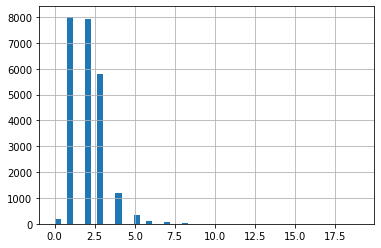

In [19]:
data['rooms'].hist(bins=50);

In [20]:
print(data['rooms'].min(),data['rooms'].max(),data['rooms'].median())
print(len(data.query('rooms==0')))

0 19 2.0
194


Очевидно, что значения 0 в столбце 'rooms' быть не может, поскольку в квартире не может быть 0 комнат, поэтому удалю все строки со значением 0

0


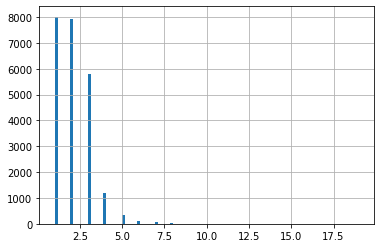

In [21]:
data=data[data['rooms']!=0]
print(len(data.query('rooms==0')))
data['rooms'].hist(bins=100);

**Высота потолков**

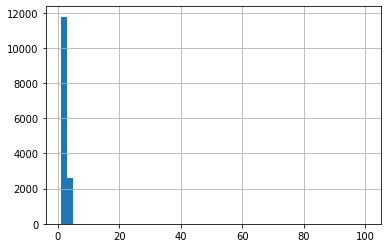

In [22]:
data['ceiling_height'].hist(bins=50);

In [23]:
print(data['ceiling_height'].min(),data['ceiling_height'].max(),data['ceiling_height'].median())

1.0 100.0 2.65


В столбце "ceiling_height" значения не могут быть 1, или 100 м, существует определенный диапазон потолков квартир, пусть потолки будут не ниже 2 метров и не выше 5 метров, чтобы убрать уж совсем нереалистичные значения

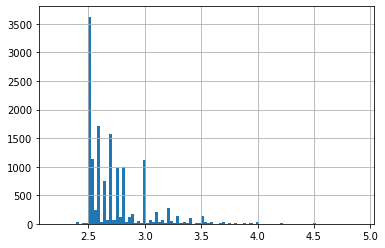

In [24]:
data=data[(data.ceiling_height>2) & (data.ceiling_height<5)]
data['ceiling_height'].hist(bins=100);

**Тип этажа**

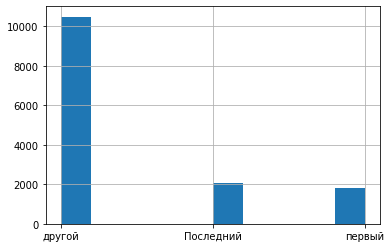

In [25]:
data['floortype'].hist();

Большая часть квартир не находится ни на первом, ни на последнем этаже, что логично, ведь в каждом доме всего по одному первому и последнему этажу и от 5 других

**Общее количество этажей в доме**

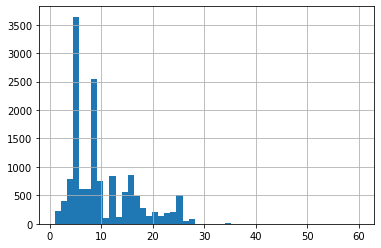

In [26]:
data['floors_total'].hist(bins=50);

In [27]:
print(data['floors_total'].min(),data['floors_total'].max(),data['floors_total'].median())

1 60 9.0


Конечно, 60 этажей это многовато для дома, однако человейники сейчас очень популярны, одноэтажные многоквартирные дома также существуют, поэтому со значениями в этом столбце все в порядке

**Расстояние до центра города в метрах**

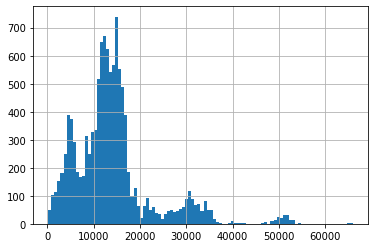

In [28]:
data['cityCenters_nearest'].hist(bins=100);

In [29]:
print(data['cityCenters_nearest'].min(),data['cityCenters_nearest'].max(),data['cityCenters_nearest'].median())

181.0 65968.0 12965.0


Квартира в 65 км от центра города звучит правдоподобно при учете того, что среди локаций встречается не только Петербург, но и малонаселенные поселки и деревни, удаленные от цивилизации. В среднем до центра города от квартир в данном датасетет ехать 13 км

**Расстояние до ближайшего парка**

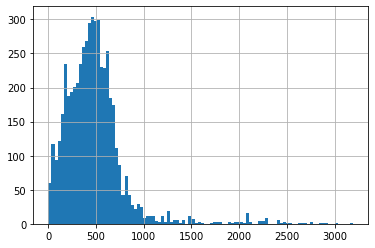

In [30]:
data['parks_nearest'].hist(bins=100);

In [31]:
print(data['parks_nearest'].min(),data['parks_nearest'].max(),data['parks_nearest'].median())

3.0 3190.0 448.0


У каких-то счастливчиков парк находится прямо под окнами, а кому-то нужно преодолеть более 3 км, чтобы оказаться в парке. В среднем парк находится не очень далеко от квартир из датасета: в пределах 500 метров

Посмотрю, какая доля от изначального количества данных осталась после фильтрации. 

In [32]:
data.shape[0]/shap*100

60.60593273977805

Поскольку у нас осталось около 98.8% значений от изначального количества, мы можем провести актуальный анализ

**4.2 Как быстро продавались квартиры**

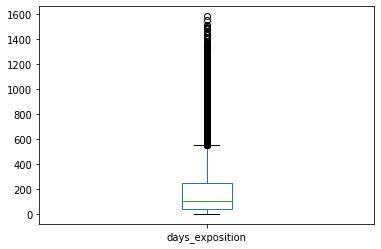

In [33]:
data['days_exposition'].plot(kind='box');

In [34]:
print(data['days_exposition'].mean(),data['days_exposition'].median())
data['days_exposition'].quantile([.25, .75])

190.6877304726785 103.5


0.25     45.0
0.75    248.0
Name: days_exposition, dtype: float64

По диаграмме размаха видно, что существует очень много выбросов, которые могут таковыми считаться после примерно 500 дней,проведенных на сайте. Быстрыми продажами могут считаться продажи до 1 квартиля, т.е от 0 до 45, а долгие продажи-те, что висят на сайте дольше 232 дней.

**4.3 Факторы, которые больше всего влияют на общую (полную) стоимость объекта**

**Зависимость цены от общей площади**

0.7111456517377345

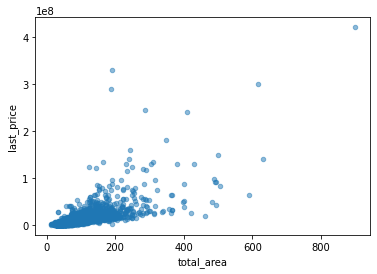

In [35]:
data.plot(x='total_area',y='last_price',kind='scatter',alpha=0.5);
data['total_area'].corr(data['last_price'])

По графику и коэффициенту корреляции Пирсона видно, что с увеличением общей площади цена за квартиру соответсвенно увеличивется.

**Зависимость цены от жилой площади**

0.7111456517377345

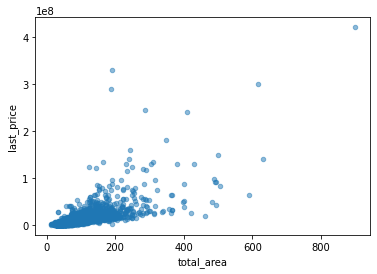

In [36]:
data.plot(x='total_area',y='last_price',kind='scatter',alpha=0.5);
data['total_area'].corr(data['last_price'])

С увеличением жилой площади стоимость, судя по графику и корреляции, также увеличивается

**Зависимость цены от площади кухни**

0.5346240554554514

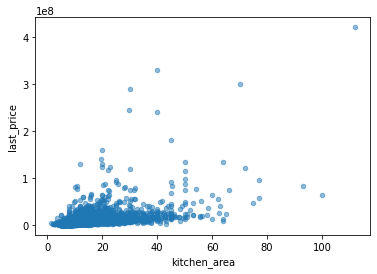

In [37]:
data.plot(x='kitchen_area',y='last_price',kind='scatter',alpha=0.5);
data['kitchen_area'].corr(data['last_price'])

В данном случае зависимость послабее, поскольку большая кухня- не гарант качества квартиры, однако положительная корреляция все еще прослеживается- с увеличением площади кухни увеличивается и стоимость.

**Зависимость цены от количества комнат**

0.4033900847032469

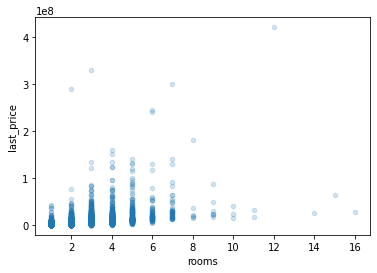

In [38]:
data.plot(x='rooms',y='last_price',kind='scatter',alpha=0.2);
data['rooms'].corr(data['last_price'])

Можно заметить, что большинство квартир с комнатами до 5 лежит в одинаковом ценовом сегменте до 100 млн рублей. Коэффициент корреляции также показывает, что зависимость достаточно слабая.

**Зависимость цены от этажа**

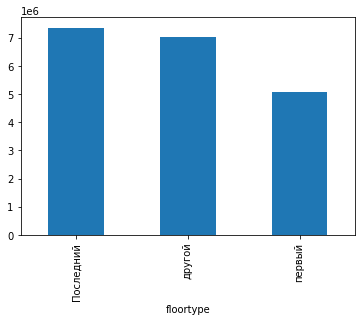

In [39]:
etazh=data.groupby('floortype')['last_price'].mean()
etazh.plot(kind='bar');

На графике видно, что квартиры на первом этаже самые дешевые, а квартиры на последнем этаже ценятся больше всего. Скорее всего, низкую цену на квартиры на первых этажах можно аргументировать плохими условиями - шум от улиц и охлаждаемость помещения зимой.


**Зависимость цены от дня недели публикации**

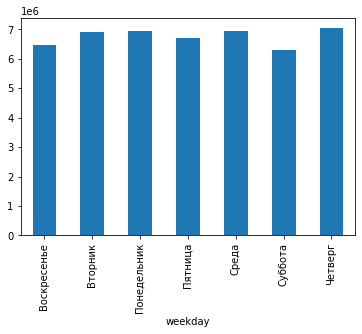

In [40]:
ned=data.groupby('weekday')['last_price'].mean()
ned.plot(kind='bar');

В четверг люди публикуют самые дорогие квартиры, а в субботу самые дорогие, но какого-то явного "популярного" или, наоборот, "непопулярного" дня нет, поэтому можно сказать, что цена квартиры не зависит от дня недели публикации.

**Зависимость цены от месяца**

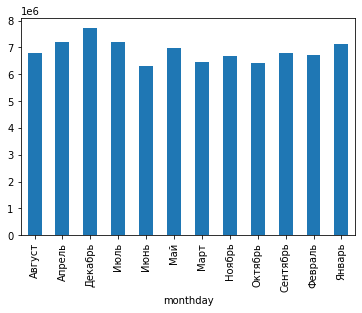

In [41]:
ned=data.groupby('monthday')['last_price'].mean()
ned.plot(kind='bar');

На графике видно, что в январе и декабре выставляются самые дорогие квартиры, а в июне самые дешевые

**Зависимость цены от года публикации**

<AxesSubplot:xlabel='year'>

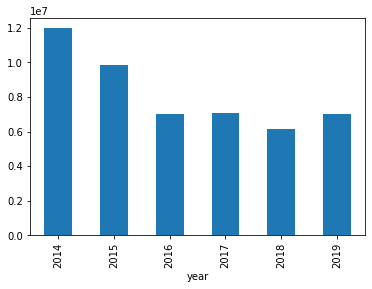

In [42]:
ned=data.groupby('year')['last_price'].mean()
ned.plot(kind='bar')

На графике видно, что квартиры в 2014 в среднем стоили дороже всего, и в последние годы цена начинает падать. Цена постоянно изменяется в зависимости от года, поэтому определенная зависимость все же есть.

**4.4 Населенные пункты с наибольшим количеством объявлений**

In [43]:
filter=data.pivot_table(index='locality_name',values='square_metr_price',aggfunc=['count','mean'])
filter.columns={'count','mean'}
filter=filter.sort_values(by='count')
filter.tail(10)

,count,mean
locality_name,,
Сестрорецк,129,102267.327209
поселокПарголово,137,90901.350730
Петергоф,145,85554.144690
Гатчина,148,70024.958919
Колпино,203,75938.525517
поселокМурино,210,87027.808429
поселокШушары,215,79244.869349
Пушкин,234,103920.487863
Всеволожск,267,67339.017378


Дороже всего квадратный метр стоит в Санкт-Петербурге, а дешевле всего в Выборге.

**4.5 Зависимость цены квартир в Санкт-Петербурге от расстояния до центра**

,last_price
km_from_cityCenters,
0.0,2.282661e+07
1.0,2.207755e+07
2.0,1.757934e+07
3.0,1.128221e+07
4.0,1.286677e+07
5.0,1.431656e+07
6.0,1.552866e+07
7.0,1.466959e+07
8.0,1.079253e+07


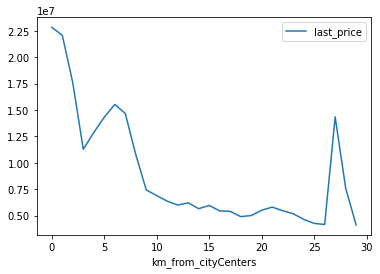

In [45]:
piter=data.query('locality_name=="Санкт-Петербург"').pivot_table(index=['km_from_cityCenters'],values='last_price',aggfunc='mean')
for i in piter.columns:
    piter[i]=piter[i].apply(lambda x:"{:f}".format(x))
piter=piter.astype(float)
piter.plot()
piter



Чем ближе квартира к центру, тем она дороже. На промежутке от 3 до 6 км наблюдается небольшой скачок в цене, однако в целом тенденция уменьшения стоимости с отдалением от центра сохраняется. На графике после 7 км заметно, что цена меняется. Это возможный центр города.


### Общий вывод

Я выяснил, что квартиры в датасете в среднем продаются за 100 дней. Также цена квартиры зависит от общей и жилой площади, что неудивительно, поскольку зачастую большая площадь предполагает более комфортную жизнь, значит за нее можно попросить побольше. Квартиры на первом этаже стоят дешевле, возможно потому что вид из окна не такой красочный, как на последних этажах. В 2014 году квартиры стоили больше всего (около 12 млн рублей), в последующие 5 лет наблюдалась тенденция спада стоимости(в 2019 около 6.5 млн рублей). В датасете дороже всего квадратный метр стоит в Санкт-Петербурге(114815.28 руб/м2), поскольку это культурный центр России и второй самый крупный город в стране, проживание в нем дает много возможностей и перспектив. В Питере стоимость квартир увеличивается по мере их приближения к центру, поскольку центр предполагает собой большое количество ресторанов, музеев и прочих активностей, территориальная близость к которым увеличивает стоимость квартиры. Так, квартиры прямо рядом с центром в среднем стоят около 30 млн рублей. На расстоянии от 3 до 6 км стоимость увеличивается(в среднем около 15 млн рублей), возможно там находится центр города. Квартиры дальше 8 км от центра в среднем стоят 5-7 млн рублей